In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys

%matplotlib inline
from IPython import display


import functions.parse_data as parse
import functions.handy_functions as hf
import torch.nn as nn
import torch


from multivariate_quantile_regression.network_model import QuantileNetwork

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from tqdm import tqdm

import os

2024-04-15 13:35:58.394734: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-15 13:35:58.428327: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-15 13:35:58.428347: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-15 13:35:58.429193: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-15 13:35:58.434797: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# Check if CUDA (GPU support) is available
if torch.cuda.is_available():
    # CUDA is available, so let's set default device to GPU
    torch.set_default_device(0)
    print("CUDA is available. Using GPU.")
else:
    # CUDA is not available, so let's use the CPU
    print("CUDA is not available. Using CPU.")

# Example usage:
tensor = torch.randn(3, 3)  # Create a tensor on the selected device
print("Tensor is on device:", tensor.device)

CUDA is available. Using GPU.
Tensor is on device: cuda:0


In [3]:
channel_labels= ['Cloud_B02','Cloud_B03','Cloud_B04','Cloud_B05','Cloud_B06','Cloud_B07',
                 'Cloud_B08','Cloud_B09','Cloud_B10','Cloud_B11','Cloud_B12','Cloud_B13']

data_water=parse.parse('cloudrm2_water_newsurf.dat')
data_clear=parse.parse('cloudrm2_clear_newsurf.dat')
data_ice=parse.parse('cloudrm2_ice_newsurf.dat')
data_mixed=parse.parse('cloudrm2_mixed_newsurf.dat')

#data_black_water=parse.parse('cloudrm_water_black_surf.dat')
#data_black_clear=parse.parse('cloudrm_clear_black_surf.dat')
#data_black_ice=parse.parse('cloudrm_ice_black_surf.dat')
#data_black_mixed=parse.parse('cloudrm_mixed_black_surf.dat')

#Concatinate all datasets
#data_all=pd.concat([data_water,data_clear,data_ice,data_mixed,
#                    data_black_water,data_black_clear,data_black_ice,data_black_mixed])

data_all=pd.concat([data_water,data_clear,data_ice,data_mixed])

data_all=data_all.drop(columns=['Surface_Desc','Cloud_B01','Clear_B01'])
data_all=data_all.reset_index()
data_all=data_all.drop(columns=('index'))

df=data_all.copy()

##Train test validation split##
#X_labels= ['Cloud_B02','Cloud_B03','Cloud_B04','Cloud_B05','Cloud_B06',
#           'Cloud_B07','Cloud_B08','Cloud_B09','Cloud_B10','Cloud_B11','Cloud_B12','Cloud_B13',
#           'Sat_Zenith_Angle','Sun_Zenith_Angle','Azimuth_Diff_Angle']

X_labels= ['Cloud_B02','Cloud_B03','Cloud_B04','Cloud_B05','Cloud_B06',
           'Cloud_B07','Cloud_B08','Cloud_B09','Cloud_B10','Cloud_B11','Cloud_B12','Cloud_B13','Sun_Zenith_Angle']
#Leave out 'GOT', 'Water_Vapor'
#Band 1 no go.
y_labels=['Clear_B02','Clear_B03','Clear_B04','Clear_B05',
              'Clear_B06','Clear_B07','Clear_B08', 'Clear_B09',
              'Clear_B10','Clear_B11','Clear_B12','Clear_B13']
#clear_labels=['Clear_B02','Clear_B03','Clear_B04','Clear_B05',
#              'Clear_B06','Clear_B07','Clear_B08', 'Clear_B09',
#              'Clear_B10','Clear_B11','Clear_B12','Clear_B13']

#y_labels= ['OCloud_B02','OCloud_B03','OCloud_B04','OCloud_B05','OCloud_B06',
#           'OCloud_B07','OCloud_B08','OCloud_B09','OCloud_B10','OCloud_B11','OCloud_B12','OCloud_B13']

#df[y_labels]=df[X_labels].to_numpy()-df[clear_labels].to_numpy()

quantiles=np.array([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])

In [4]:
## Estimate COT ##
from cot_train.utils import StatCollector, MLP5, mlp_inference
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_load_paths=['cot_model_new_surf/0/model_it_2000000','cot_model_new_surf/1/model_it_2000000',
                  'cot_model_new_surf/2/model_it_2000000','cot_model_new_surf/3/model_it_2000000',
                  'cot_model_new_surf/4/model_it_2000000']

input_dim = 13
output_dim = 1

models_cot=[]
for model_path in model_load_paths:
    model_cot = MLP5(input_dim, output_dim, apply_relu=True)
    model_cot.load_state_dict(torch.load(model_path, map_location=device))
    model_cot.to(device)
    models_cot.append(model_cot)

means=[0.538923,0.530993,0.579427,0.630218,0.759563,0.807696,0.767415,0.839607,0.402664,0.066681,0.442786,0.344600,58.065838]
stds=[0.199267,0.175733,0.179156,0.165408,0.157317,0.157984,0.151002,0.158407,0.232892,0.096684,0.313212,0.220723,15.569941]

inputs = (df[X_labels].to_numpy() - means) / stds

image_input_tens=torch.Tensor(inputs).to(device)
#image_pred_cot=model_cot(image_input_tens).cpu().data.numpy()*50

preds = 0
for model_cot in models_cot:
    curr_preds=model_cot(image_input_tens)/len(models_cot)
    preds=preds+curr_preds

image_pred_cot=preds.cpu().data.numpy()*50 #unnormalise

## Reshape back
t_is_cloud = 0.025*50 # From Alex
t_thin_cloud = 0.015*50 # From Alex

im_pred_cot_t=image_pred_cot.copy()
im_pred_cot_t[im_pred_cot_t<t_thin_cloud]=0
im_pred_cot_t[(im_pred_cot_t>t_thin_cloud)&(im_pred_cot_t<t_is_cloud)]=1
im_pred_cot_t[im_pred_cot_t>t_is_cloud]=2
column_name='COT_est'
c1='clear'
c2='thin'
c3='thick'
df[column_name]=im_pred_cot_t
df.loc[df[column_name]==0,c1]=1
df.loc[df[column_name]!=0,c1]=0
df.loc[df[column_name]==1,c2]=1
df.loc[df[column_name]!=1,c2]=0
df.loc[df[column_name]==2,c3]=1
df.loc[df[column_name]!=2,c3]=0

X_labels.append(c1)
X_labels.append(c2)
X_labels.append(c3)

In [5]:
df

,Cloud_B02,Cloud_B03,Cloud_B04,Cloud_B05,Cloud_B06,Cloud_B07,Cloud_B08,Cloud_B09,Cloud_B10,Cloud_B11,...,Azimuth_Diff_Angle,COT,Cloud_Type,Profile_ID,GOT,Water_Vapor,COT_est,clear,thin,thick
0,0.94195,0.87799,0.92936,0.93407,0.95181,0.96217,0.92871,0.97181,0.49957,0.04136,...,167.66,5.897,3,3335,0.126,0.35,2.0,0.0,0.0,1.0
1,0.30422,0.40100,0.27834,0.57800,1.01964,1.02787,1.00519,1.03599,0.59139,0.01055,...,161.91,1.275,2,1996,0.126,0.31,1.0,0.0,1.0,0.0
2,0.28715,0.25066,0.30366,0.29214,0.34088,0.40079,0.37376,0.48750,0.02092,0.00067,...,168.52,1.799,1,6796,0.127,4.04,1.0,0.0,1.0,0.0
3,0.27146,0.33719,0.19841,0.46411,0.88787,0.89584,0.87746,0.90439,0.51811,0.00561,...,165.49,0.519,2,3701,0.123,0.22,0.0,1.0,0.0,0.0
4,0.39689,0.38594,0.32623,0.37338,0.60678,0.66895,0.55343,0.70168,0.01513,0.00049,...,148.48,8.569,2,6345,0.128,5.40,2.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,0.34326,0.33065,0.30906,0.54799,0.69691,0.70308,0.69751,0.71081,0.51136,0.05396,...,129.09,1.917,8,3565,0.105,0.13,2.0,0.0,0.0,1.0
199996,0.67538,0.60192,0.63624,0.64307,0.71627,0.72744,0.68661,0.73124,0.29566,0.00216,...,66.61,49.992,10,9149,0.124,1.02,2.0,0.0,0.0,1.0
199997,0.80019,0.76760,0.78372,0.82218,0.97845,0.98619,0.94268,0.98844,0.79426,0.31875,...,157.58,32.589,9,3055,0.125,0.54,2.0,0.0,0.0,1.0
199998,0.80365,0.71523,0.77816,0.80325,0.81675,0.82206,0.81107,0.82767,0.60124,0.11536,...,174.63,5.619,10,1403,0.107,0.16,2.0,0.0,0.0,1.0


In [6]:
X=df[X_labels]
y=df[y_labels]

X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.1)

In [7]:
import random

val_size=0.1
validation_indices=np.array(random.sample(range(len(X_train['Cloud_B02'])), int(len(data_all['Cloud_B02'])*val_size)))
train_indices=[i for i in range(len(X_train['Cloud_B02'])) if np.any(validation_indices==i)==False]

---No improvement in 100 epochs, broke early---
Best model out of total max epochs found at epoch 599
Model all saved...


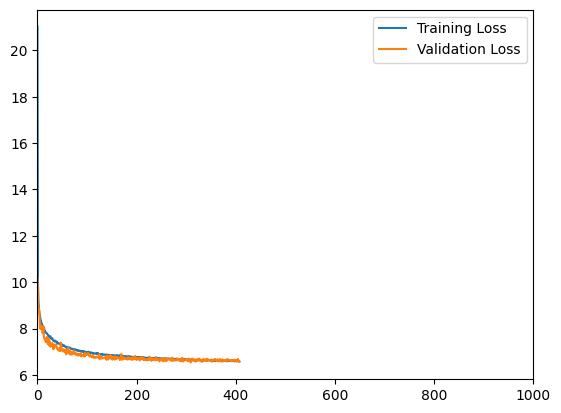

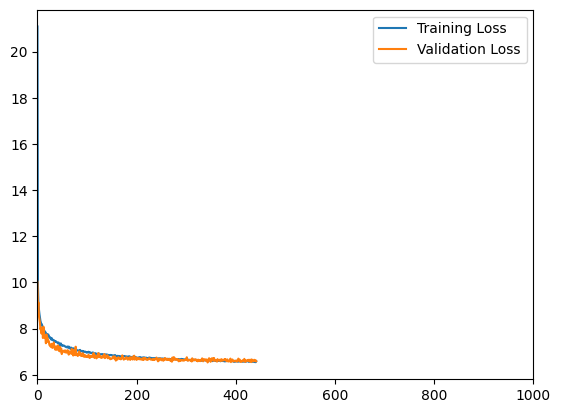

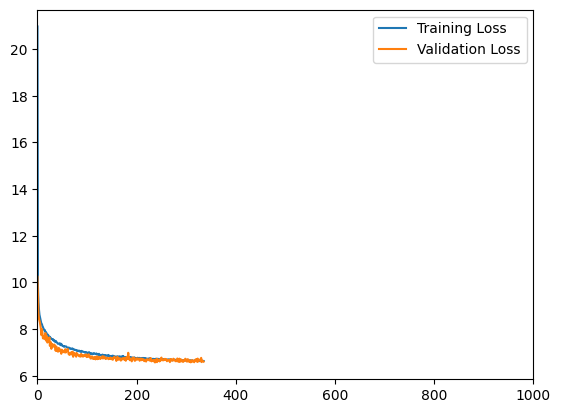

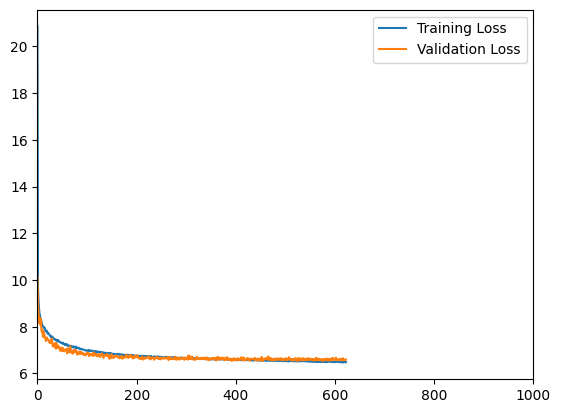

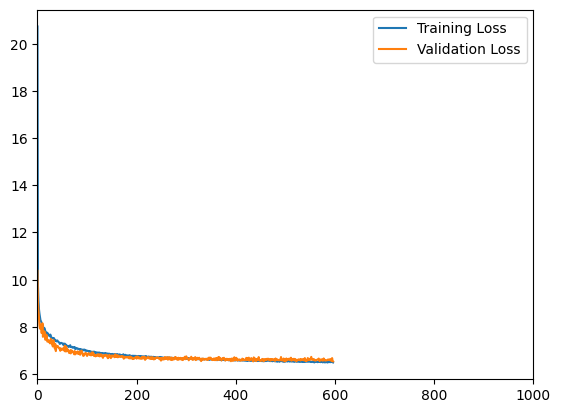

In [8]:
batch_size=500
save=True
ensamble=5

nepochs=1000
models=[QuantileNetwork(quantiles=quantiles) for i in range(ensamble)]

n_nodes_all=200

sequence_all=lambda: nn.Sequential(
    nn.Linear(len(X_labels),n_nodes_all),
    nn.ReLU(),
    nn.BatchNorm1d(n_nodes_all),
    nn.Linear(n_nodes_all,n_nodes_all),
    nn.ReLU(),
    nn.BatchNorm1d(n_nodes_all),
    nn.Linear(n_nodes_all,n_nodes_all),
    nn.ReLU(),
    nn.BatchNorm1d(n_nodes_all),
    nn.Linear(n_nodes_all,n_nodes_all),
    nn.ReLU(),
    nn.BatchNorm1d(n_nodes_all),
    nn.Linear(n_nodes_all, len(quantiles)*len(y_labels)) #Output dimesion is number of quantiles times number of target variables
)


for i,model in enumerate(models):
    main_filepath="pytorch_models/cont_test"
    model.fit(X_train.to_numpy(),y_train.to_numpy(), 
            train_indices, 
            validation_indices, 
            batch_size=batch_size,
            nepochs=nepochs,
            sequence=sequence_all(),
            lr=0.002,
            data_norm=True,
            verbose=False,
            plot_training=True,
            early_break=True)

    if save:
        filepath=main_filepath+'/model'+str(i)
        os.makedirs(filepath,exist_ok=True)
        torch.save(model,filepath+'/model_file')
        print("Model all saved...")
if save:
    X_test.to_csv(main_filepath+'/xtest.csv',index=True)
    y_test.to_csv(main_filepath+'/ytest.csv',index=True)
    df.to_csv(main_filepath+'/df.csv',index=True)


In [9]:

main_filepath='pytorch_models/cont_test'
n_ensemble=5
models=[]
for i in range(n_ensemble):
    models.append(torch.load(main_filepath+'/model'+str(i)+'/model_file'))

X_test=pd.read_csv(main_filepath+'/xtest.csv',index_col=0)
y_test=pd.read_csv(main_filepath+'/ytest.csv',index_col=0)
y_true=y_test.to_numpy()

In [10]:
X_test = X_test + np.random.randn(np.shape(X_test)[0],np.shape(X_test)[1]) * np.mean(X_test.to_numpy(),axis=0)*0.02

In [11]:
for i,model in enumerate(models):
    if i==0:
        pred_y=model.predict(X_test.to_numpy())
    else:   
        pred_y=pred_y+model.predict(X_test.to_numpy())
pred_y=pred_y/len(models)

In [12]:
from functions.plot_metrics import plot_metrics
from functions import calc_metrics

/home/edgelab/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/edgelab/.local/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/edgelab/filip/SEEX30_Cloud_Fog/SEEX30_Cloud_Fog/Cloud_rm/functions/plot_metrics.py:222: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  ax.errorbar(x=np.linspace(0,len(y_pred_sort_samp[i][:,index_median]),len(y_pred_sort_samp[i][:,index_median]))


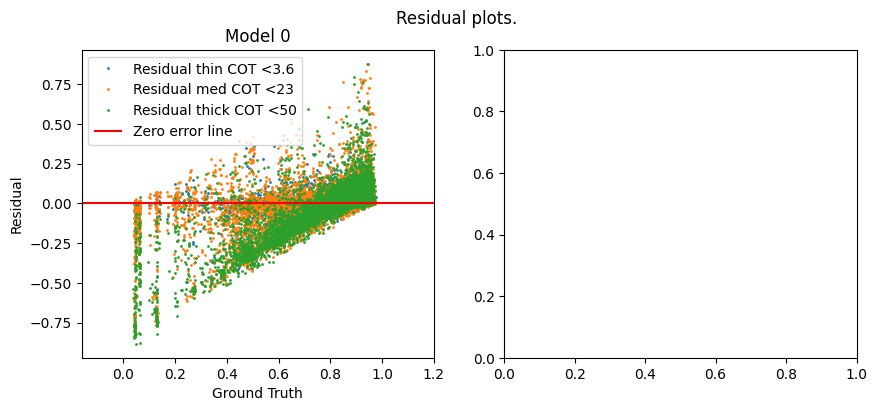

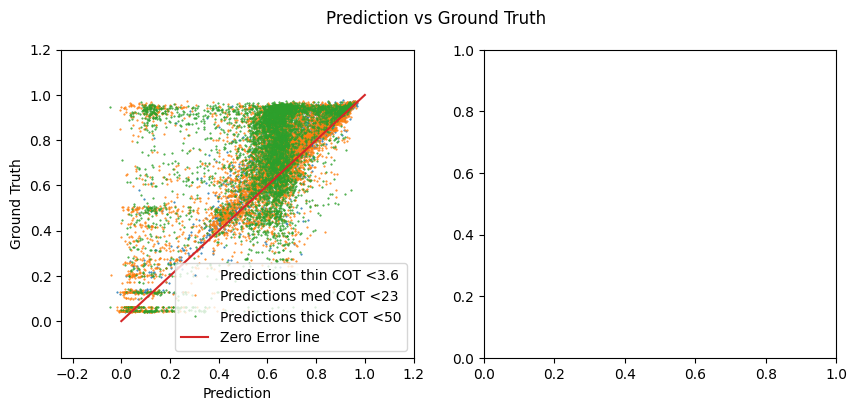

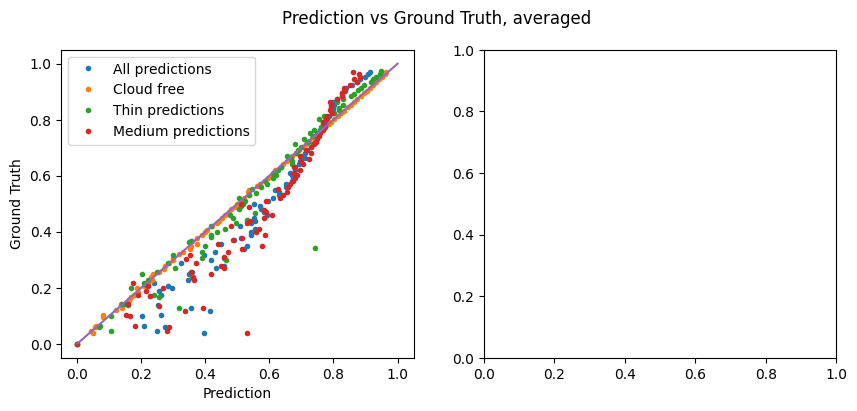

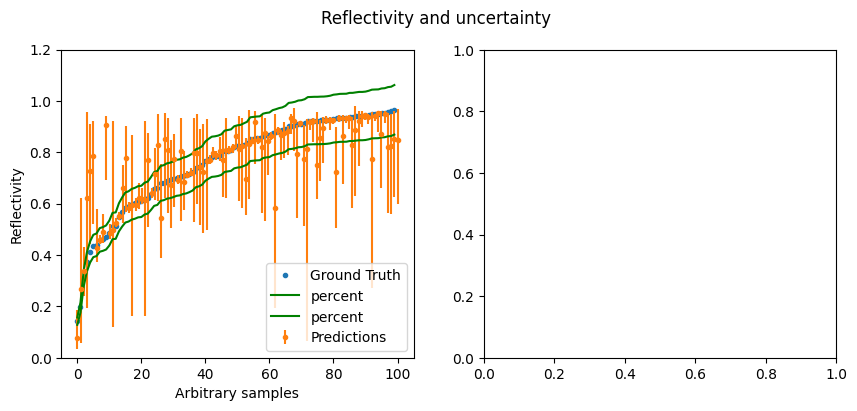

In [13]:
plt.rcParams["figure.figsize"] = [10, 4]
figs,axs,mses,r2s,psnrs,quantrates,quantcrosses = plot_metrics([models],
                                                                [X_test],
                                                                [y_test],
                                                                [pred_y],
                                                                df,
                                                                samples=100,
                                                                nrows=1,
                                                                ncols=2,
                                                                is_ensemble=True,
                                                                index_median=4)

In [14]:
MSE=[]
R2=[]
PSNR=[]
quantrates=[]
quantcross=[]

MSE.append(mean_squared_error(y_true,pred_y[:,:,4]))
R2.append(r2_score(y_true,pred_y[:,:,4]))
PSNR.append(calc_metrics.PSNR(y_true,pred_y[:,:,4]))
quantrates.append(calc_metrics.quant_rate(y_true,pred_y))
quantcross.append(calc_metrics.quant_cross(pred_y))

In [15]:

print("MSE: "+str(MSE[0]))
print(" ")
print("R2 score: "+str(R2[0]))
print(" ")
print("PSNR: "+str(PSNR[0]))
print(" ")
print("Quantrate: "+str(quantrates[0]))
print(" ")
print("Quantile crossing: "+str(quantcross[0]))

MSE: 0.005221019274946978
 
R2 score: 0.8833250117774263
 
PSNR: 22.85239670597768
 
Quantrate: [0.06651667 0.14100833 0.22769583 0.330675   0.45596667 0.58915
 0.72877917 0.84436667 0.93355417]
 
Quantile crossing: 0.0
